In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
(x_train_image,y_train_label),(x_test_image,y_test_label) = tf.keras.datasets.cifar10.load_data()
x_train_normalize = x_train_image.astype('float32')/255
x_test_normalize = x_test_image.astype('float32')/255
y_train_OneHot = tf.keras.utils.to_categorical(y_train_label)
y_test_OneHot = tf.keras.utils.to_categorical(y_test_label)

In [4]:

import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow as tf


class SqueezeNet(keras.Model):

    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.conv1 = layers.Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.act1 = Mish()
        self.pool1 = layers.MaxPool2D(3, strides=2, padding='same')
        self.fire_block2 = FireBlock(16, 64, 64)
        self.fire_block3 = FireBlock(16, 64, 64)
        self.fire_block4 = FireBlock(32, 128, 128)
        self.pool4 = layers.MaxPool2D(3, strides=2, padding='same')
        self.fire_block5 = FireBlock(32, 128, 128)
        self.fire_block6 = FireBlock(48, 192, 192)
        self.fire_block7 = FireBlock(48, 192, 192)
        self.fire_block8 = FireBlock(64, 256, 256)
        self.pool8 = layers.MaxPool2D(3, strides=2, padding='same')
        self.fire_block9 = FireBlock(64, 256, 256)

    def __call__(self, inputs=None):
        if not inputs:
            #inputs = keras.Input(shape=(224, 224, 3))
            inputs = keras.Input(shape=(32, 32, 3))

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)  # C2
        x = self.fire_block2(x)
        x = self.fire_block3(x)
        x = self.fire_block4(x)
        x = self.pool4(x)  # C3
        x = self.fire_block5(x)
        x = self.fire_block6(x)
        x = self.fire_block7(x)
        x = self.fire_block8(x)
        x = self.pool8(x)  # C4
        x = self.fire_block9(x)

        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(10,activation='softmax')(x)

        squeezenet = keras.Model(inputs, x)
        return squeezenet


class FireBlock(layers.Layer):

    def __init__(self, filter1, filter2, filter3):
        super(FireBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters=filter1, kernel_size=1, padding='same', use_bias=False)
        self.conv2 = layers.Conv2D(filters=filter2, kernel_size=1, padding='same', use_bias=False)
        self.conv3 = layers.Conv2D(filters=filter3, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

    def __call__(self, inputs):
        squeeze_x = self.conv1(inputs)
        squeeze_x = self.bn1(squeeze_x)
        squeeze_x = Mish()(squeeze_x)
        expand_x1 = self.conv2(squeeze_x)
        expand_x1 = self.bn2(expand_x1)
        expand_x1 = Mish()(expand_x1)
        expand_x3 = self.conv3(squeeze_x)
        expand_x3 = self.bn3(expand_x3)
        expand_x3 = Mish()(expand_x3)

        merge_x = layers.Concatenate()([expand_x1, expand_x3])

        return merge_x


class Mish(layers.Layer):

    def __init__(self):
        super(Mish, self).__init__()

    def __call__(self, inputs):
        return tf.multiply(inputs, tf.tanh(tf.nn.softplus(inputs)))


if __name__ == '__main__':
    squeeze_net = SqueezeNet()
    model = squeeze_net()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 96)   14112       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 96)   384         conv2d_2[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Softplus (TensorFlo [(None, 16, 16, 96)] 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
#model = keras.models.Model(input,x)
squeeze_net = SqueezeNet()
model = squeeze_net()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_train = model.fit(x=x_train_normalize,y=y_train_OneHot,validation_split=0.2,epochs=10,batch_size=300,verbose=1)

Epoch 1/10
134/134 [==============================] - 7s 52ms/step - loss: 1.6333 - accuracy: 0.4067 - val_loss: 2.8308 - val_accuracy: 0.0997
Epoch 2/10
134/134 [==============================] - 5s 41ms/step - loss: 1.2668 - accuracy: 0.5426 - val_loss: 3.2541 - val_accuracy: 0.1172
Epoch 3/10
134/134 [==============================] - 5s 41ms/step - loss: 1.0905 - accuracy: 0.6104 - val_loss: 1.7776 - val_accuracy: 0.4016
Epoch 4/10
134/134 [==============================] - 5s 41ms/step - loss: 0.9547 - accuracy: 0.6614 - val_loss: 1.5761 - val_accuracy: 0.4983
Epoch 5/10
134/134 [==============================] - 5s 41ms/step - loss: 0.8409 - accuracy: 0.7034 - val_loss: 1.2382 - val_accuracy: 0.5828
Epoch 6/10
134/134 [==============================] - 5s 41ms/step - loss: 0.7488 - accuracy: 0.7341 - val_loss: 1.1902 - val_accuracy: 0.6102
Epoch 7/10
134/134 [==============================] - 5s 41ms/step - loss: 0.6545 - accuracy: 0.7696 - val_loss: 1.3147 - val_accuracy: 0.5986

In [6]:
def train_history(model_train,train,val):
    plt.plot(model_train.history[train])
    plt.plot(model_train.history[val])
    plt.title('Train History')
    plt.xlabel('epoch')
    plt.ylabel(train)
    plt.legend(['train','validation'],loc='upper left')

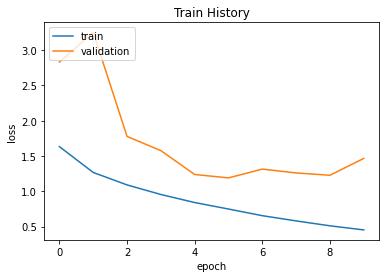

In [7]:
train_history(model_train,'loss','val_loss')

In [8]:
scores = model.evaluate(x_test_normalize,y_test_OneHot,verbose=2)

313/313 - 1s - loss: 1.4857 - accuracy: 0.5923


In [9]:
model.save('./SqueezeNet.h5', save_format="h5")